In [ ]:
# Author: Pierre Jeanne
# Date Created:  07 July 2021

# National Stock Exchange Dataset - Banking Sectors

## 5 years of National Stock Price data (January 2016 to May 2021) of several banks

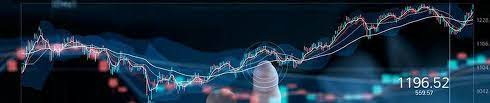

## ARIMA 
tha general process for ARIMA models is the following:
- Visualize the Time Series Data,
- Make the time series stationary,
- Plot the Correlation and AutoCorrelation charts,
- construct the ARIMA Model,
- Use the model to make predictions.

In [ ]:
import numpy as np
import pandas as pd
import datetime
from datetime import date
import holidays

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# stat on data
from scipy import stats
from scipy.stats import norm, skew 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

# model evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">1: Exploratory Data Analysis
</p>
</div>

**1.1: Load the data**

In [ ]:
df = pd.read_csv(r"../input/national-stock-exchange-banking-sectors/NSE_BANKING_SECTOR.csv")
df.tail()

We can notice that some days are missing.

**Columns Descriptors:**

`Date`: date on which data is recorded

`SYMBOL`: Stock symbol according to NSE

`SERIES`: Different series in which a particular stock could be traded

`PREV CLOSE`: Previous day closing price

`OPEN`: Day's opening price

`HIGH`: Day's Highest Price

`LOW`: Day's Lowest Price

`LAST`: Day's Last Price

`CLOSE`: Day's Closing Price

`VWAP`: volume-weighted average price is the ratio of the value traded to total volume traded over a particular time horizon

`Volume`: the amount of a security that was traded during a given period of time. For every buyer, there is a seller, and each
transaction contributes to the count of total volume.

`Turnover`: Total Turnover of the stock till that day

`Trades`: Number of buy or Sell of the stock.

`Deliverable`: Volume the quantity of shares which actually move from one set of people (who had those shares in their demat account before today and are selling today) to another set of people (who have purchased those shares and will get those shares by T+2 days in their demat account).

%Deliverble: percentage deliverables of that stock

**1.2: General information**

In [ ]:
print('shape of the dataset: ', df.shape)

In [ ]:
# missing value:
df.isnull().sum()

In [ ]:
# data type
df.dtypes

In [ ]:
# set date as index
df['DATE'] = pd.to_datetime(df['DATE'],format='%Y-%m-%d', errors='ignore')
df = df.set_index('DATE')

**1.3: basic stats numerical variables**

In [ ]:
df.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

**1.4: basic stats categorical variables**

In [ ]:
# describe categorical data
df.describe(include=[object])

In [ ]:
# drop series (has a unique value)
df=df.drop('SERIES',axis=1)

In [ ]:
# look at 'SYMBOL' distribution
pie_ax=df['SYMBOL'].value_counts(normalize=True).plot.pie(figsize=(9,9),legend=True,
                                                          shadow=True, autopct='%1.1f%%',
                                                          pctdistance=0.75, radius=1.05,
                                                          wedgeprops = {'linewidth': 0.1},
                                                          textprops = {'fontsize': 9})

pie_ax.set_title('SYMBOL', fontsize=16, weight='bold')
pie_ax.legend(fancybox=True, shadow=True, title='SYMBOL', fontsize=11,loc='upper right', bbox_to_anchor=(1.5, 1.2))
pie_ax.set_ylabel("")
plt.show()

**1.4: Time series visualisation**

In [ ]:
# create list with all the 'symbol'
list_symbol = df['SYMBOL'].unique().tolist()
print(len(list_symbol))

In [ ]:
fig = plt.figure(figsize=(15,60))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

for i,symbol in zip(range(1,len(list_symbol)),list_symbol):
    ax = fig.add_subplot(18,2,i)
    df1 = df[df['SYMBOL']==symbol]
    ax = sns.lineplot(x=df1.index, y = 'PREV CLOSE',data=df1,label=symbol,ci=None)
    ax.set_xlim([datetime.date(2015,8,1),datetime.date(2021,8,1)])

- We can see that time series contians either very few data or stop in 2019, we will mot work on these time series: `IDFCBANK`, `EQUITASBNK`,`SURYODAY`

In [ ]:
# Time series to remove:
symbol_to_remove = ['IDFCBANK', 'EQUITASBNK','SURYODAY']
for symbol in symbol_to_remove:
    list_symbol.remove(symbol)

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">2: Missing date and missing values
</p>
</div>

**2.1: sampling rate**

In [ ]:
df=df.reset_index()
df['diff'] = df.groupby('SYMBOL')['DATE'].diff() / np.timedelta64(1, 'D')
df['diff'] = df['diff'].fillna(0)


In [ ]:
fig = plt.figure(figsize=(15,60))
fig.subplots_adjust(hspace=0.4,wspace=0.3)
fig.suptitle('Time difference between two consecutive time steps',fontsize=16,y=0.89)

for i,symbol in zip(range(1,37),list_symbol):
    ax = fig.add_subplot(18,2,i)
    df1 = df[df['SYMBOL']==symbol]
    ax = sns.lineplot(x='DATE', y = 'diff',data=df1,label=symbol)
    ax.set_xlim([datetime.date(2015,8,1),datetime.date(2021,8,1)])

The sampling rate is not constant. The difference in date range mostly from 1 to 3 days. May be there are no data during the weekend?

In [ ]:
df['days_of_week'] = df['DATE'].dt.dayofweek
df['days_of_week'].describe()

The days of week range from Monday to Sunday, so the missing dates are not related to the weekend.

**2.2: Add the missing date**

In [ ]:
# find the last date
df.tail(1)

In [ ]:
# Creating a datetimeindex with dailly frequency (no missing date)
idx = pd.date_range(start='2006-01-01', end='2021-05-28', freq='D')
idx = pd.DataFrame(idx,columns=['DATE'])
idx = idx.set_index('DATE')
idx.head(3)

In [ ]:
# set date as index
df=df.set_index('DATE')
# create empty dataframe
df2 = pd.DataFrame()
# create a df for each symbol, and add to it the missing date
for symbol in list_symbol:
    df1 = df[df['SYMBOL']==symbol]
    beginning_date = df1.index[0]
    ending_date = df1.index[-1]
    # add missing day
    df_symbol = pd.concat([idx,df1],axis=1)
    df_symbol = df_symbol[(df_symbol.index >= beginning_date)&
                          (df_symbol.index <= ending_date)]
    # replace NaN values in "SYMBOL"
    df_symbol['SYMBOL'] = symbol
    df2 = pd.concat([df2,df_symbol],axis=0)


In [ ]:
# calculate delta time between two dates
df2 = df2.reset_index()
df2['diff'] = df2.groupby('SYMBOL')['DATE'].diff() / np.timedelta64(1, 'D')
df2['diff'] = df2['diff']

# calculate the days of the week
df2['days_of_week'] = df2['DATE'].dt.dayofweek

# calculate the month of the year
df2['month'] = df2['DATE'].dt.month

# get vacation days
ind_holidays = holidays.India()
df2['Holiday'] = df2['DATE'].isin(ind_holidays)

In [ ]:
# plot difference between two concecutive date to verify time step
fig = plt.figure(figsize=(15,60))
fig.subplots_adjust(hspace=0.4,wspace=0.3)
fig.suptitle('Time difference between two consecutive time steps',fontsize=16,y=0.89)

for i,symbol in zip(range(1,37),list_symbol):
    ax = fig.add_subplot(18,2,i)
    df3 = df2[df2['SYMBOL']==symbol]
    ax = sns.lineplot(x='DATE', y = 'diff',data=df3,label=symbol)
    ax.set_xlim([datetime.date(2015,8,1),datetime.date(2021,8,1)])

In [ ]:
# set Date as index
df2 = df2.set_index('DATE')
df2.head(3)

**2.3 : replace the nan values**

In [ ]:
# number of missing value before interpolation
df2.isnull().sum()

In [ ]:
# fill missing value with linear interpolation
df = df2.interpolate(method='linear')

In [ ]:
# verify result
df.isnull().sum()

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">3: Summarizing the values in the time series data
</p>
</div>

**3.1: EDA time series**

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(15,15),sharex = True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

axs0, axs1, axs2, axs3, axs4, axs5, axs6, axs7, axs8, axs9, axs10, axs11  = axes.flatten() 
fig.suptitle('Distribution of the stock prices',fontsize=16,y=0.92)

sns.boxplot(x='SYMBOL', y= 'PREV CLOSE', data=df,ax=axs0)
sns.boxplot(x='SYMBOL', y= 'OPEN', data=df,ax=axs1)
sns.boxplot(x='SYMBOL', y= 'HIGH', data=df,ax=axs2)
sns.boxplot(x='SYMBOL', y= 'LOW', data=df,ax=axs3)
sns.boxplot(x='SYMBOL', y= 'LAST', data=df,ax=axs4)
sns.boxplot(x='SYMBOL', y= 'CLOSE', data=df,ax=axs5)
sns.boxplot(x='SYMBOL', y= 'VWAP', data=df,ax=axs6)
sns.boxplot(x='SYMBOL', y= 'VOLUME', data=df,ax=axs7)
sns.boxplot(x='SYMBOL', y= 'TURNOVER', data=df,ax=axs8)
sns.boxplot(x='SYMBOL', y= 'TRADES', data=df,ax=axs9)
sns.boxplot(x='SYMBOL', y= 'DELIVERABLE VOLUME', data=df,ax=axs10)
sns.boxplot(x='SYMBOL', y= '%DELIVERBLE', data=df,ax=axs11)

axs10.set_xticklabels(axs10.get_xticklabels(),rotation=90)
axs11.set_xticklabels(axs11.get_xticklabels(),rotation=90)
    
plt.show()

- `PREV CLOSE`, `OPEN`, `HIGH`, `LOW`, `LAST`, `CLOSE`, and `VWAP` are very similar. 

- The other variables have many outliers

**3.2: Daily evolution stock price** 

In [ ]:
# groupby days and calculate mean
df_by_days = df.groupby('days_of_week').mean()
# get variables names
list_numeric = df_by_days.columns[:-3]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4,wspace=0.3)
fig.suptitle('Weekly evolution of the predictors',fontsize=16,y=0.92)

for i,var in zip(range(1,len(list_numeric)),list_numeric):
    ax = fig.add_subplot(len(list_numeric)/2,2,i)
    ax = sns.lineplot(x=df_by_days.index, y = var,data=df_by_days)

- The stocks goes up during the week (Wednesday to Friday) and to down during the weekend. 

- Because of this weekly  seasonality component I will use a 7 window for calculating the rolloing mean and std.

**3.3: Monthly evolution stock price** 

In [ ]:
# groupby days and calculate mean
df_by_month = df.groupby('month').mean()
# get variables names
list_numeric = df_by_month.columns[:-3]

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
fig.suptitle('Monthly evolution of the predictors',fontsize=16,y=0.92)


for i,var in zip(range(1,len(list_numeric)),list_numeric):
    ax = fig.add_subplot(len(list_numeric)/2,2,i)
    ax = sns.lineplot(x=df_by_month.index, y = var,data=df_by_month)

During the summer months the prices goes up and the transaction goes down.

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">4: Correlation between time series
</p>
</div>

In [ ]:
# Computing percent changes
df['PREV CLOSE_pct'] = df['PREV CLOSE'].pct_change()
df['OPEN_pct'] = df['OPEN'].pct_change()
df['HIGH_pct'] = df['HIGH'].pct_change()
df['LOW_pct'] = df['LOW'].pct_change()
df['LAST_pct'] = df['LAST'].pct_change()
df['CLOSE_pct'] = df['CLOSE'].pct_change()
df['VWAP_pct'] = df['VWAP'].pct_change()
df['VOLUME_pct'] = df['VOLUME'].pct_change()
df['TURNOVER_pct'] = df['TURNOVER'].pct_change()
df['TRADES_pct'] = df['TRADES'].pct_change()
df['DELIVERABLE VOLUME_pct'] = df['DELIVERABLE VOLUME'].pct_change()
df['%DELIVERBLE_pct'] = df['%DELIVERBLE'].pct_change()

list_col_pct = ['PREV CLOSE_pct','OPEN_pct', 'HIGH_pct', 'LOW_pct', 'LAST_pct', 'CLOSE_pct', 'VWAP_pct','VOLUME_pct',
                'TURNOVER_pct', 'TRADES_pct', 'DELIVERABLE VOLUME_pct','%DELIVERBLE_pct']

In [ ]:
corr_p = df[list_col_pct].corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr_p,annot=True,linewidths=.5, annot_kws={"size": 12},vmin=-1.0, vmax=1.0,
               square=True)
plt.show()

## split the time serie

In [ ]:
df_train_data = pd.DataFrame()
df_test_data = pd.DataFrame()

for symbol in list_symbol:
    df0 = df[df['SYMBOL']==symbol]
    train_data, test_data = df0[:int(len(df0)*0.9)], df0[int(len(df0)*0.9):]
    df_train_data = pd.concat([df_train_data,train_data],axis=0)
    df_test_data = pd.concat([df_test_data,test_data],axis=0)
    
df_train_data = df_train_data
df_test_data = df_test_data

In [ ]:
df_train_data.shape

In [ ]:
df_example_split_data_train = df_train_data[df_train_data['SYMBOL']=='ICICIBANK']
df_example_split_data_test  = df_test_data[df_test_data['SYMBOL']=='ICICIBANK']
# plot the time series with the different steps
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.6,wspace=0.4)

# subplot
ax1 = fig.add_subplot(1,1,1)
ax1 = df_example_split_data_train['PREV CLOSE'].plot(label = 'train data', color='k')
ax1 = df_example_split_data_test['PREV CLOSE'].plot(label = 'test data',color='g')
ax1.legend()
ax1 = plt.title("Examples of how we split the time series data",fontsize=16)

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">5: verify the stationarity of time series data
</p>
</div>


**What is the stationarity**

Stationarity means that the statistical properties of a a time series (or rather the process generating it) do not change over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

**5.1: Tests to verify the stationarity -- Rolling statisics**

In [ ]:
# get variables names of interest
list_var = ['PREV CLOSE', 'VOLUME','TURNOVER','TRADES','DELIVERABLE VOLUME', '%DELIVERBLE']

# loop over the target variable and create a figure object
for var in list_var:
    fig = plt.figure(figsize=(15,60))
    fig.subplots_adjust(hspace=0.6,wspace=0.4)
    fig.suptitle('Rolling average and std for {}'.format(var),fontsize=18,weight='bold', color= 'blue', y=0.89)
    
    # loop over SYMBOL to plot the different stock withing the target variable
    for i,symbol in zip(range(1,len(list_symbol)),list_symbol):
        # create subplot
        ax = fig.add_subplot(len(list_symbol)/2,3,i)
        # add title
        ax.set_title(symbol, fontsize=14, weight='bold')
        # select stock
        df1 = df_train_data[df_train_data['SYMBOL']==symbol]
        # compute a weekly and monthly rolling average
        rolmean7d = df1[var].rolling(window=7).mean()
        rolstd7d = df1[var].rolling(window=7).std()
        rolmean1y = df1[var].rolling(window=365).mean()
        rolstd1y = df1[var].rolling(window=365).std()
        # plot the result
        ax = sns.lineplot(x = df1.index,y = var,data = df1,color ='blue', label='Original',ci=None)
        ax = sns.lineplot(x = df1.index,y = rolmean7d,data = df1, color='red', label='Rolling Mean 7d',linewidth=3,ci=None)
        ax = sns.lineplot(x = df1.index,y = rolstd7d,data = df1, color='black', label='Rolling Std 7d',linewidth=3,ci=None)
        ax = sns.lineplot(x = df1.index,y = rolmean1y,data = df1, color='green', label='Rolling Mean 1 year',linewidth=3,ci=None)
        ax = sns.lineplot(x = df1.index,y = rolstd1y,data = df1, color='c', label='Rolling Std 1 year',linewidth=3,ci=None)
        # set xlim
        ax.set_xlim([datetime.date(2015,8,1),datetime.date(2021,8,1)])
        # remove legend every where
        ax.get_legend().remove()
        # but keep legend for the first subplot
        ax0 = plt.subplot(len(list_symbol)/2,3,1)
        ax0.legend(loc='best')
        
plt.show()

At a first glance, we can easily spot some time series with a trend and/or a saisonality, so they are not stationary. However, it is hard to clearly identify if all the time series are stationary or not just by looking at them. So, to be sure we will check the data stationarity with The Dickey-Fuller test.

## 5.2: Tests to verify the stationarity -- The Dickey-Fuller test

Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [ ]:
# create empty lists
result_adfuller = []

for var in list_numeric:
    for symbol in list_symbol:
        df1 = df_train_data[df_train_data['SYMBOL']==symbol]
        df1_test = adfuller(df1[var],autolag = 'AIC')
        dfoutput = pd.Series(df1_test[0:4], index=['test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key, value in df1_test[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        result_adfuller.append(tuple((var, symbol,dfoutput[0],dfoutput[1],dfoutput[2],dfoutput[4],dfoutput[5],dfoutput[6])))

# create DataFrame with the result of the Dickey-Fuller test
df_result_adfuller = pd.DataFrame(result_adfuller, columns =['variable','symbol','test Statistic','p-value','#Lags Used',
                                            'Critical values 1%','Critical values 5%','Critical values 10%'])


In [ ]:
# create figure object
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4,wspace=0.3)
# figure title
fig.suptitle("Check the results of the stationary time series:", fontsize=18)
# subplot
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(data=df_result_adfuller, x=df_result_adfuller.index, y='p-value',s=60)
ax1.axhline(y=0.05, color='g', linestyle='--')
ax1 = plt.title('p-value')
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(data=df_result_adfuller, x=df_result_adfuller.index, y='test Statistic',s=60)
ax2 = sns.lineplot(data=df_result_adfuller, x=df_result_adfuller.index, y='Critical values 1%',ci=None)
ax2 = sns.lineplot(data=df_result_adfuller, x=df_result_adfuller.index, y='Critical values 5%',ci=None)
ax2.set_ylim(-15,0)
ax2 = plt.title('test statistic vs critical values')
plt.show()

Only few varaiables have a p-values below 0.05, and even then, many of them have a test Statistic bewteen Critical Values of 1% and 5 %. So, the data needs to be transformed to get it stationary. First, we will transform the data with log to remove the trend.

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">6: Make Time Series Stationary
</p>
</div>


Though stationarity assumption is taken in many Time Series models, almost none of practical time series are stationary (and its almost impossible to make a series perfectly stationary). So statisticians have figured out ways to make series stationary. Here, we will :

**6.1: Make the Time series stationary**

In [ ]:
# create empty df to store differenciate time series
df_train_data_log = pd.DataFrame()
df_train_data_log_diff = pd.DataFrame()
df_test_data_single_var = pd.DataFrame()
    
# loop over list with non-stationary time series    
for i, row_in_df_non_stat in df_result_adfuller.iterrows():
    # select these time series in df
    columns = row_in_df_non_stat['variable']
    rows = row_in_df_non_stat['symbol']
    df1 = df_train_data.loc[:,[columns,'SYMBOL']]
    df1 = df1[df1['SYMBOL']==rows]
    df2 = df_test_data.loc[:,[columns,'SYMBOL']]
    df2 = df2[df2['SYMBOL']==rows]
    # step 1:  stabilise the variance and reduce the magnitude by taking the log
    df1['log_{}_{}'.format(columns,rows)] = np.log(df1[columns])
    df2['{}_{}'.format(columns,rows)] = df2[columns]
    # step 2: eliminating trend and seasonality by differencing the time series
    df1['diff_log_{}_{}'.format(columns,rows)] = np.log(df1[columns]).diff()
    # clean df:
    df1 = df1.iloc[1:]
    df1 = df1.drop([columns,'SYMBOL'], axis=1)
    df2 = df2.drop([columns,'SYMBOL'], axis=1)
    
    # send result to dataframes: df_train_data_log_diff  and df_test_data_single_var
    df_test_data_single_var = pd.concat([df_test_data_single_var,df2], axis=1) 
    df_train_data_log = pd.concat([df_train_data_log,df1], axis=1) 
    df_train_data_log = df_train_data_log.drop(['diff_log_{}_{}'.format(columns,rows)],axis=1)
    df_train_data_log_diff = pd.concat([df_train_data_log_diff,df1], axis=1)     
    df_train_data_log_diff = df_train_data_log_diff.drop(['log_{}_{}'.format(columns,rows)],axis=1)
    #

In [ ]:
result_adfuller_diff = []
for columns in df_train_data_log_diff.columns:
    df2 = pd.DataFrame()
    df2 = df_train_data_log_diff[columns].dropna()
    df2_test = adfuller(df2,autolag = 'AIC')
    dfoutput = pd.Series(df2_test[0:4], index=['test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in df2_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    result_adfuller_diff.append(tuple((var, symbol,dfoutput[0],dfoutput[1],dfoutput[2],dfoutput[4],dfoutput[5],dfoutput[6])))

# create DataFrame with the result of the Dickey-Fuller test
df_result_adfuller_diff = pd.DataFrame(result_adfuller_diff, columns =['variable','symbol','test Statistic','p-value','#Lags Used',
                                            'Critical values 1%','Critical values 5%','Critical values 10%'])

# create figure object
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4,wspace=0.3)
# figure title
fig.suptitle("Check the results of the stationary time series after log and differenciation:", fontsize=18)
# subplot
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.scatterplot(data=df_result_adfuller_diff, x=df_result_adfuller_diff.index, y='p-value',s=60)
ax1.axhline(y=0.05, color='g', linestyle='--')
ax1.set(yscale="log")
ax1 = plt.title('p-value')
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(data=df_result_adfuller_diff, x=df_result_adfuller_diff.index, y='test Statistic',s=60)
ax2 = sns.lineplot(data=df_result_adfuller_diff, x=df_result_adfuller_diff.index, y='Critical values 1%',ci=None)
ax2 = sns.lineplot(data=df_result_adfuller_diff, x=df_result_adfuller_diff.index, y='Critical values 5%',ci=None)
ax2 = plt.title('test statistic vs critical values')
plt.show()

- This is much better! The p-values are very low (up to 10E-28) and all the test statistic are well below the Critical values of 1%.

**6.4: Summary**

Here, I just show a summary of what I did before for only one time serie: 'PREV CLOSE' for`ICICIBANK`.
- step 1: take the log to stabilise the variance and reduce the magnitude of the data
- step 2: Differencing the time series to stabilise the mean by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality

In [ ]:
# step 0 : select the time series
columns = 'PREV CLOSE'
rows = 'ICICIBANK'
df_summary = df_train_data.loc[:,[columns,'SYMBOL']]
df_summary = df_summary[df_summary['SYMBOL']==rows]
# step 1:  stabilise the variance and reduce the magnitude by taking the log
df_summary['log_{}_{}'.format(columns,rows)] = np.log(df_summary[columns])
# step 2: eliminating trend and seasonality by differencing the time series
df_summary['diff_log_{}_{}'.format(columns,rows)] = df_summary['log_{}_{}'.format(columns,rows)].diff()

In [ ]:
# plot the time series with the different steps
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.6,wspace=0.4)

# figure title
fig.suptitle("Summary of the steps to make the time series stationary, example with: 'PREV CLOSE' and symbol = 'ICICIBANK' :", fontsize=16, y=1.02)

# subplot
ax1 = fig.add_subplot(1,3,1)
df_example = df_train_data[df_train_data['SYMBOL']=='ICICIBANK']
ax1 = df_example['PREV CLOSE'].plot(label = 'ts')
ax1.legend()
ax1 = plt.title('initial time series: ts')
# 
ax2 = fig.add_subplot(1,3,2)
ax2 = df_summary['log_PREV CLOSE_ICICIBANK'].plot(color='g',label='log(ts)')
ax2.legend()
ax2 = plt.title('step1: log  time series')
# 
ax3 = fig.add_subplot(1,3,3)
ax3 = df_summary['diff_log_PREV CLOSE_ICICIBANK'].plot(color='k',label='log(ts n)-log(ts n-1)')
ax3.legend()
ax3 = plt.title('step2: calculate weighted moving average')

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">6: Building ARIMA models
</p>
</div>


## ARIMA 

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. **Number of Differences (d)**: d is the degree of differencing (the number of times the data have had past values subtracted). In this case : **d=1**. 

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers:  **Autocorrelation Function (ACF)**: and the **Partial Autocorrelation Function (PACF)**.

The ACF and PACF plots for the TS after differencing can be plotted as:

**6.1: Partial Autocorrelations to find the order of the AR term (p):**
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

In [ ]:
fig = plt.figure(figsize=(18,900))
fig.subplots_adjust(hspace=0.6,wspace=0.4)

for i, columns in enumerate(df_train_data_log_diff.columns):
    # select these time series
    df2 = df_train_data_log_diff[columns].dropna()
    ax0 = fig.add_subplot(int(df_train_data_log_diff.shape[0]/2),3,i+1)
    plot_pacf(df2,lags=40,title=i, ax = ax0)
    ax0 = plt.ylim(-0.2,0.2)
plt.show()

- The Time series number 0 to 230 show:
    - a very low spike at lag 1
    - and several lower spikes around lags 7, 14, 21 showing a weekly effect.


- The time series number 231 to 395:
    - a very low spike at lag 1, that decrease after a few lags.

**6.2: Autocorrelation Function (ACF) to find the order of the MA term (q):**
- The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.
- Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
- in other words, it measure how much influence past prices have on its future price.

In [ ]:
fig = plt.figure(figsize=(18,900))
fig.subplots_adjust(hspace=0.6,wspace=0.4)

for i, columns in enumerate(df_train_data_log_diff.columns):
    # select these time series
    df2 = df_train_data_log_diff[columns].dropna()
    ax0 = fig.add_subplot(int(df_train_data_log_diff.shape[0]/2),3,i+1)
    plot_acf(df2,lags=30,title=i, ax = ax0)
    ax0 = plt.ylim(-0.2,0.2)
plt.show()

- The autocorrelations show a large spike at lag 1 followed by a damped wave that alternates between positive and negative correlations, with the higher values at lag 7, 14 and 21 showing the weekly effect.

In [ ]:
fig = plt.figure(figsize=(18,900))
fig.subplots_adjust(hspace=0.6,wspace=0.4)

for i, columns in enumerate(df_train_data_log_diff.columns):
    # select these time series
    df2 = df_train_data_log_diff[columns].dropna()
    ax0 = fig.add_subplot(int(df_train_data_log_diff.shape[0]/2),3,i+1)
    pd.plotting.lag_plot(df2, ax = ax0)
plt.show()

The above curves represent the relation between current time step and its previous time step. we can see:
- The data come from an underlying autoregressive model poorly to moderate negative autocorrelation
- The data contain few outliers.

So to conclude on this part, the ACF and PACF shows that we may try different model to predict. However, we will start with a simple model for all the time series and chooce the following parameters for the ARIMA models:
- p = 1
- d = 1
- q = 1

<div style="
           border-radius:50px;
           background-color:#7ca4cd;
           font-size:200%;
           font-family:Arial;
           letter-spacing:0.10px">
<p style="padding: 10px;
          color:white;
          text-align:center;">7: Time series prediction
</p>
</div>

### Analyze the result
To see how these models perform, we can plot:
- their residual, which should look like a white noise.
- and the residual distribution to see if the residuals have a normal distribution.

In [ ]:
list_rmse =[]
df_result_fit_value = pd.DataFrame()
df_forecast = pd.DataFrame()
df_lower_conf_int = pd.DataFrame()
df_upper_conf_int = pd.DataFrame()

fig = plt.figure(figsize=(18,900))
fig.subplots_adjust(hspace=0.6,wspace=0.2)
for i, columns in enumerate(df_train_data_log.columns):
    df_log=pd.DataFrame()
    # load the data
    df_log = df_train_data_log[columns].dropna()
    df_log_diff = df_train_data_log_diff.iloc[:,i].dropna()
    df3 = pd.DataFrame(df_test_data_single_var.iloc[:,i]).dropna()
    # built and fit the model 
    model = ARIMA(df_log, order=(1,1,1))  
    model_fitted = model.fit()
    results_fit = model_fitted.fittedvalues
    # make forecast:
    n = df3.shape[0]
    forecast, se, conf = model_fitted.forecast(n)
    # scale back the forecast
    forecast = np.exp(forecast)
    lower_conf = np.exp(conf[:, 0])
    upper_conf = np.exp(conf[:, 1])
    # Save the forecast:
    forecast    = pd.Series(forecast, index=df3.index)
    lower_conf = pd.Series(lower_conf, index=df3.index)
    upper_conf = pd.Series(upper_conf, index=df3.index)
    df_forecast  = pd.concat([df_forecast,forecast],axis=1)
    df_upper_conf_int = pd.concat([df_upper_conf_int,upper_conf],axis=1)
    df_lower_conf_int = pd.concat([df_lower_conf_int,lower_conf],axis=1)
        
    ax0 = fig.add_subplot(int(df_train_data_log_diff.shape[0]/2),3,i+1)
    ax0 = plt.plot(df_log_diff)
    ax0 = plt.plot(results_fit, color='red')
    ax0 = plt.title(i)
    rmse = sqrt(mean_squared_error(df_log_diff.iloc[1:], results_fit))
    list_rmse.append(rmse)
    df_result_fit_value = pd.concat([df_result_fit_value,results_fit], axis=1) 
    
plt.show()

In [ ]:
# give columns names
df_forecast.columns = df_test_data_single_var.columns
df_upper_conf_int.columns =df_test_data_single_var.columns
df_lower_conf_int.columns = df_test_data_single_var.columns

## analyse the fit results

In [ ]:
def built_fit_model(num_ts):
    # select ts:
    df_ts = df_train_data_log.iloc[:,num_ts].dropna()
    df_ts_diff = df_train_data_log_diff.iloc[:,num_ts].dropna()
    # built and fit the model 
    model = ARIMA(df_ts, order=(1, 1, 1))  
    results = model.fit()
    x_ts = pd.DataFrame(results.fittedvalues,columns=['fittedvalues'])
    y_ts = pd.DataFrame(df_ts_diff)
    x_ts['residual'] = x_ts['fittedvalues'] - y_ts.iloc[:,0]
    return df_ts_diff, x_ts

df_ts_diff_1, x_ts_1 = built_fit_model(1)
df_ts_diff_50, x_ts_50 = built_fit_model(50)
df_ts_diff_150, x_ts_150 = built_fit_model(150)
df_ts_diff_300, x_ts_300 = built_fit_model(300)
df_ts_diff_325, x_ts_325 = built_fit_model(325)
df_ts_diff_350, x_ts_350 = built_fit_model(350)

# plot the results:
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
fig.suptitle("Zoom on few time series:", fontsize=16)
# subplot
ax1 = fig.add_subplot(3,3,1)
ax1 = plt.plot(df_ts_diff_1)
ax1 = plt.plot(x_ts_1['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_1.iloc[1:], x_ts_1['fittedvalues']))
ax1 = plt.title('RMSE: %.4f'% RMSE)

ax2 = fig.add_subplot(3,3,2)
ax2 = plt.plot(df_ts_diff_50)
ax2 = plt.plot(x_ts_50['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_50.iloc[1:], x_ts_50['fittedvalues']))
ax2 = plt.title('RMSE: %.4f'% RMSE)
 
ax3 = fig.add_subplot(3,3,3)
ax3 = plt.plot(df_ts_diff_150)
ax3 = plt.plot(x_ts_150['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_150.iloc[1:], x_ts_150['fittedvalues']))
ax3 = plt.title('RMSE: %.4f'% RMSE)
 
ax4 = fig.add_subplot(3,3,4)
ax4 = plt.plot(df_ts_diff_300)
ax4 = plt.plot(x_ts_300['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_300.iloc[1:], x_ts_300['fittedvalues']))
ax4 = plt.title('RMSE: %.4f'% RMSE)

ax5 = fig.add_subplot(3,3,5)
ax5 = plt.plot(df_ts_diff_325)
ax5 = plt.plot(x_ts_325['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_325.iloc[1:], x_ts_325['fittedvalues']))
ax5 = plt.title('RMSE: %.4f'% RMSE)
 
ax6 = fig.add_subplot(3,3,6)
ax6 = plt.plot(df_ts_diff_350)
ax6 = plt.plot(x_ts_350['fittedvalues'], color='red')
RMSE = sqrt(mean_squared_error(df_ts_diff_350.iloc[1:], x_ts_350['fittedvalues']))
ax6 = plt.title('RMSE: %.4f'% RMSE)

It is good, it looks like white noises.

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# figure title
fig.suptitle("Residual Distributions:", fontsize=18)

# subplot
ax1 = fig.add_subplot(3,3,1)
ax1 = sns.distplot(x_ts_1['residual'], fit=norm)
ax1 = plt.title('residual distriburion ts1')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_1['residual'])
ax1 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax2 = fig.add_subplot(3,3,2)
ax2 = sns.distplot(x_ts_50['residual'], fit=norm)
ax2 = plt.title('residual distriburion ts50')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_50['residual'])
ax2 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax3 = fig.add_subplot(3,3,3)
ax3 = sns.distplot(x_ts_150['residual'], fit=norm)
ax3 = plt.title('residual distriburion ts50')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_150['residual'])
ax3 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax4 = fig.add_subplot(3,3,4)
ax4 = sns.distplot(x_ts_300['residual'], fit=norm)
ax4 = plt.title('residual distriburion ts50')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_300['residual'])
ax4 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax5 = fig.add_subplot(3,3,5)
ax5 = sns.distplot(x_ts_325['residual'], fit=norm)
ax5 = plt.title('residual distriburion ts50')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_325['residual'])
ax5 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

ax6 = fig.add_subplot(3,3,6)
ax6 = sns.distplot(x_ts_350['residual'], fit=norm)
ax6 = plt.title('residual distriburion ts50')
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x_ts_350['residual'])
ax6 = plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

The residual are normally distributed so our models are good!

## Analyse the forecast

In [ ]:
for  columns in df_test_data_single_var.columns:         
    train = 'log_{}'.format(columns)
    train = np.exp(df_train_data_log[train])
    ax = sns.lineplot(x = df_train_data_log.index,y = train,data = df_train_data_log,color ='k',ci=None)
    ax = sns.lineplot(x = df_test_data_single_var.index,y = columns,data = df_test_data_single_var,color ='g',ci=None)
    ax = sns.lineplot(x = df_forecast.index,y = columns,data = df_forecast,color ='orange',ci=None)
    ax = plt.fill_between(df_upper_conf_int.index, df_lower_conf_int[columns], df_upper_conf_int[columns],color='k', alpha=.10)
    ax = plt.title(columns)
    plt.show()